In [1]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
from utils.plotTools import plot_qwak


In [2]:
def inf_line_bessel_oriented10(k,nx,t,alpha,theta,gamma,l):
    domain = np.arange(0, nx) - nx//2
    prob = np.zeros([nx,1], dtype='complex')
    for x in range(1,nx):
        prob[x,0] = ( (np.cos(theta)**2) * (sp.jv(domain[x] + k, 2*t)**2)
                     + (np.sin(theta)**2) * (sp.jv(domain[x] - k, 2*t)**2)
                     + 2*((-1)**k)*np.cos(2*alpha*k + gamma)*np.cos(theta)*np.sin(theta)*sp.jv(domain[x] + k, 2*t)*sp.jv(domain[x] - k, 2*t))

    return prob

def getMultipleProbs(k,n,theta,l,gamma,alphaList,timeList):
    timeListList = [timeList]*len(alphaList)
    probListAux = []
    probList = []

    for alpha in alphaList:
        for t in timeList:
            psi_oriented = inf_line_bessel_oriented10(k,n,t,alpha,theta,gamma,l)
            probListAux.append(np.sum(psi_oriented[n//2-k-1:n//2+k+2]))
        probList.append(probListAux)
        probListAux = []

    return probList

def getWeightedGraph(graph,weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = np.conj(weight)
    return nx.compose(graph,revGraph)

# Single walk

<class 'int'>
<class 'numpy.float64'>
bla0
bla1


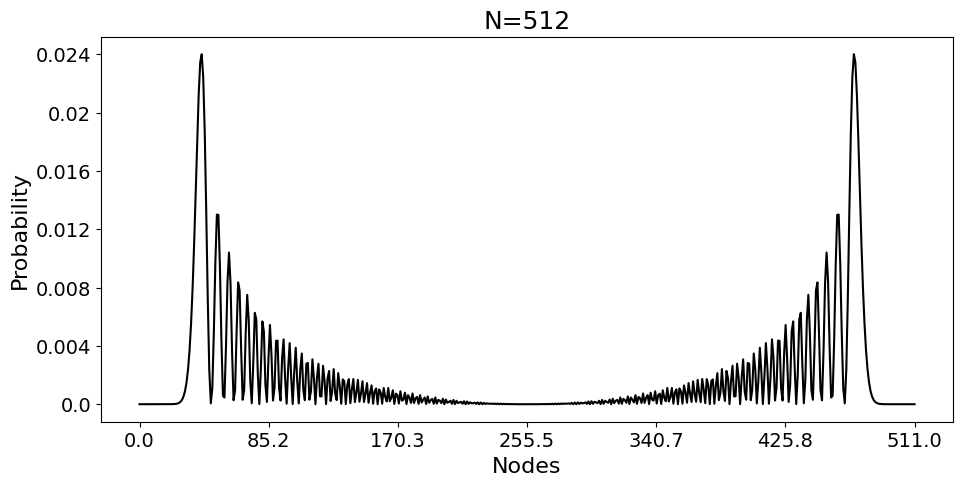

In [3]:
n=9
N = 2**n
alpha=np.pi/2

weight = np.exp(1j*alpha)
baseGraph = nx.path_graph(N,create_using=nx.DiGraph)

graph = getWeightedGraph(baseGraph,weight)

k = 1
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
l = 0
gamma = l * np.pi

t = 110
initCond = [(N//2-k,(np.cos(theta))),(N//2+k,(np.exp(1j*gamma)*np.sin(theta)))]

qw = QWAK(graph,gamma=1)
qw.runWalk(t,customStateList=initCond)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'N={N}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    'legend_labels' : None,
    'legend_loc': "best",
    'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#000000'],
    'line_style_list' : ['-'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
}

print(type(list(range(0,N))[0]))
print(type(qw.getProbVec()[0]))
plot_qwak(x_value_matrix = list(range(0,N)), y_value_matrix = qw.getProbVec(),**params)

# Multiple walks

In [4]:
def multiple_oriented_walks(N,baseGraph,alphaList,initCond):
    probList = []
    for alpha in alphaList:
        weight = np.exp(1j*alpha)
        graph = getWeightedGraph(baseGraph,weight)
        qw = QWAK(graph)
        qw.runWalk(time=t,customStateList=initCond)
        probList.append(qw.getProbVec())
    return probList

In [5]:
n = 9
N=2**n
print(N)

alpha=np.pi/2
alphaList = [0, np.pi/4, np.pi/2]
alphaLabelList = [r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']

baseGraph = nx.path_graph(N,create_using=nx.DiGraph)

k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
    
l = 0
gamma = l * np.pi

t = 110
initCond = [(N//2-k,np.cos(theta)),(N//2+k,np.exp(1j*gamma)*np.sin(theta))]

probMatrix = multiple_oriented_walks(N,baseGraph,alphaList,initCond)

512


<class 'list'> <class 'numpy.ndarray'>


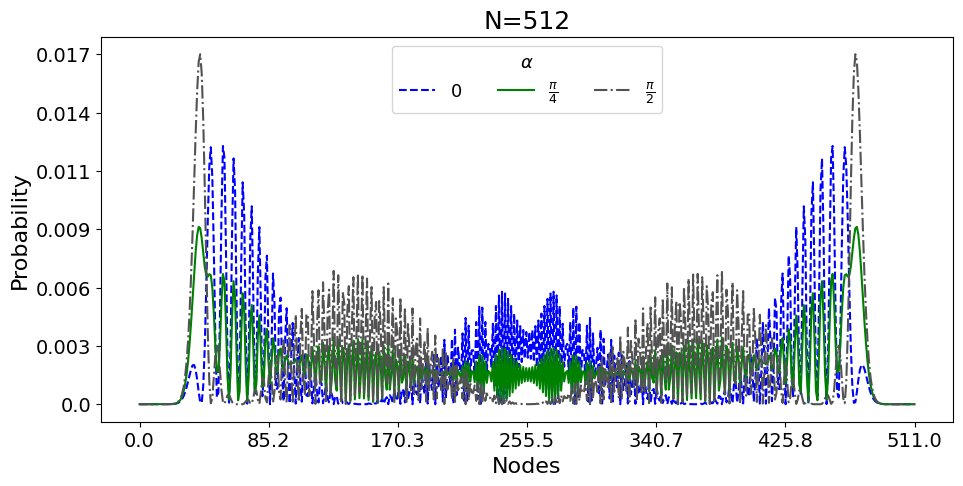

In [7]:

node_value_matrix = [list(range(0,N))]*len(probMatrix)
params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'N={N}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
}
print(type(node_value_matrix[0]), type(probMatrix[0]))
plot_qwak(x_value_matrix = node_value_matrix, y_value_matrix = probMatrix,**params)